#Import Libraries


In [1]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
#@title
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-03-27 03:55:22--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.9MB/s    in 0.9s    

2020-03-27 03:55:23 (16.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [2]:
#@title
#installion requirements for GENSIM
import os
!pip install --upgrade gensim

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"   #set environment variable
  !java -version      #check java version
install_java()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','test','%%subject%%','be','dd'])
#re
import re
import numpy as np
import pandas as pd
from pprint import pprint


#gensim
import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import datapath


#spacy 
!pip install spacy
import spacy
!python -m spacy download en_core_web_lg


#plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

import os.path
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.1)
openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


# Import Dataset

In [0]:
data_df = pd.read_csv(r'/gdrive/My Drive/KAEMH/EmailSpamAnalysis/All_Email_Campaigns_02042020.csv')
df_sample=data_df.sample(frac=0.10)

In [0]:
def display_all(df):
  """ Function to display the whole dataframe"""
  with pd.option_context("display.max_rows",1000):
    with pd.option_context("display.max_columns",1000):
      display(df)

In [0]:
display_all(data_df)

In [0]:
data_df['FromName'].unique()

#Filter by Alumni and Enterprise marketing hub communication

In [0]:
def FilterByString(stringlist, substrfilter):

  """Filter string by substring"""

  return[string for string in stringlist if
          any(substring in string for substring in substrfilter)]        

In [0]:
data_df.dtypes

In [0]:
SubStringFilter=['alumni','marketing']

Filtered_df=pd.DataFrame(data_df[data_df['FromName'].str.lower().str.contains('|'.join(SubStringFilter),na=False)])
Filtered_df

In [0]:
Filtered_df[Filtered_df['DimBusinessUnitId']==87]

In [9]:
Filtered_df['FromName'].unique()

array(['ASU Enterprise Marketing Hub', 'ASU Alumni Partners',
       'ASU Alumni', 'ASU EOSS Marketing', 'ASU Marketing Academy',
       'School of Sustainability Alumni',
       'Dan Dillon, Chief Marketing Officer',
       'ASU Alumni | News and Events', 'ASU alumni',
       'Arizona State University Enterprise Marketing Hub',
       'ASU School for the Future of Innovation in Society Alumni Group',
       'ASU Alumni Association President and CEO',
       'Martha Byrd, ASU Alumni', 'Paul Gediman, Director of Marketing',
       'Alumni Association of the School for the Future of Innovation in Society',
       'Ann Toca, Chief Marketing Officer'], dtype=object)

In [0]:
businessId_list=Filtered_df['DimBusinessUnitId'].unique()
filter_filter_df =pd.DataFrame(Filtered_df [['DimCampaignId','DimBusinessUnitId','Subject']])
filter_filter_df

#Data Pre-Processing with Spacy and Gensim

In [10]:
#convert the data to a list(SAMPLE)

data_list_sample = Filtered_df['Subject']

data_list_sample


753       [Test]:This Sun Devil Rewards summer flash sal...
765            [Test]:You Could Save $509 On Auto Insurance
779                                             ASU????????
801       [Test]:Reminder: Share your thoughts for a cha...
802       [Test]:Share your thoughts for a chance to win...
                                ...                        
106068    Daily Email Marketing Report for %%=Format(Dat...
106069            In case you missed it: Meet ASU’s new CMO
106338    Daily Email Marketing Report for %%=Format(Dat...
106542    Daily Email Marketing Report for %%=Format(Dat...
106739    Daily Email Marketing Report for %%=Format(Dat...
Name: Subject, Length: 5678, dtype: object

In [0]:
data_list = Filtered_df['Subject'].dropna()
data_list=data_list.values.tolist()
data_list

In [0]:
# Remove Emails
data_list = [re.sub('\S*@\S*\s?', '', sent) for sent in data_list]

# Remove new line characters
data_list = [re.sub('\s+', ' ', sent) for sent in data_list]

# Remove distracting single quotes
data_list = [re.sub("\'", "", sent) for sent in data_list]
data_list

In [0]:
#preprocess for the subject lines

def custom_cleaner(doc):

  tokens= [token.lemma_.lower()
              for token in doc 
                  if (
                    
                    len(token) >=2 and
                    token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] and
                    token.text in nlp.vocab and
                    not token.like_url and
                    not token.like_num and
                    not token.is_digit and
                    not token.is_punct and
                    not token.is_space and
                    not token.is_stop    
                  )      
          ] 
  return ' '.join(tokens)

In [0]:
nlp = spacy.load('en_core_web_lg',disable=['parser','ner'])

nlp.add_pipe(custom_cleaner,name='cleaner',last=True)

clean_corpus = list(nlp.pipe(data_list))
clean_corpus_list= [i.split() for i in clean_corpus]
clean_corpus_list

In [0]:
# using gensim simple_preprocess - Additional preprocessing 

def sample_prepro(data):
  for sent in data:
      yield(gensim.utils.simple_preprocess(sent,deacc= True))

data_words = list(sample_prepro(clean_corpus))
data_words

In [16]:


bigram = gensim.models.Phrases(data_words,min_count=2 ,threshold=20)
trigram= gensim.models.Phrases(bigram[data_words],threshold=20)

#use the above mdoels to come up with the phrases

bigram_list=gensim.models.phrases.Phraser(bigram)
trigram_list = gensim.models.phrases.Phraser(trigram)

#printing the bigram and trigram

print(list(bigram_list[data_words]))
print(list(trigram_list[bigram_list[data_words[0]]]))

[['reward', 'summer', 'flash_sale', 'inside', 'secret_word'], ['save', 'auto_insurance'], [], ['share', 'thought', 'chance', 'win'], ['thought', 'chance', 'win'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['save_hundred'], [], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['boat', 'football', 'information'], ['professional_development', 'opportunity'], ['professional_development', 'opportunity'], ['invite', 'enjoy_delicious', 'brunch'], ['invite', 'enjoy_delicious', 'brunch'], ['invite', 'enjoy_delicious', 'brunch'], [], ['professional_development', 'opportunity'], ['professional_development', 'opportunity'], ['special', 'offer', 'celebrate', 'graduation'], ['invite', 'enjoy_delicious', 'brunch'], ['update', 'involve_fall'], ['update', 'inv

In [0]:
#remove extra stop words from the bigrams, trigrams and lemmetization


def remove_stopwords(texts):
  return [[word for word in gensim.utils.simple_preprocess(str(doc))if word not in stop_words]for doc in texts]

def make_bigrams(texts):
  return [bigram_list[doc] for doc in texts]

def make_trigrams(texts):
  yield ([trigram_list[doc] for doc in texts])



In [18]:
#function call for removal of additional stop_words and making bi-grams

data_words = remove_stopwords(data_words)

print(data_words)

data_words_final = make_bigrams(data_words)

[['reward', 'summer', 'flash', 'sale', 'inside', 'secret', 'word'], ['save', 'auto', 'insurance'], [], ['share', 'thought', 'chance', 'win'], ['thought', 'chance', 'win'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['save', 'hundred'], [], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['boat', 'football', 'information'], ['professional', 'development', 'opportunity'], ['professional', 'development', 'opportunity'], ['invite', 'enjoy', 'delicious', 'brunch'], ['invite', 'enjoy', 'delicious', 'brunch'], ['invite', 'enjoy', 'delicious', 'brunch'], [], ['professional', 'development', 'opportunity'], ['professional', 'development', 'opportunity'], ['special', 'offer', 'celebrate', 'graduation'], ['invite', 'enj

#Dictionary and corpus - **Gensim**

In [0]:
#term document frequency

id2word = corpora.Dictionary(data_words_final)

corpus = [id2word.doc2bow(text) for text in data_words_final]
corpus

#Creating LDA Model

In [0]:
#training the model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 4,
                                           random_state=10,
                                           update_every=10,
                                           minimum_probability = 0.01,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [54]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"chance" + 0.040*"win" + 0.039*"thought" + 0.034*"join" + '
  '0.032*"share" + 0.032*"event" + 0.024*"miss" + 0.021*"register" + '
  '0.018*"regalia" + 0.017*"discount"'),
 (1,
  '0.048*"news" + 0.043*"tailgate" + 0.041*"alumnus" + 0.032*"day" + '
  '0.026*"care" + 0.023*"invite" + 0.022*"chapter" + 0.018*"career" + '
  '0.016*"summer" + 0.014*"ready"'),
 (2,
  '0.065*"new" + 0.062*"event" + 0.032*"ticket" + 0.022*"alumnus" + '
  '0.018*"newsletter" + 0.017*"free" + 0.016*"student" + 0.016*"graduation" + '
  '0.015*"season" + 0.015*"family"'),
 (3,
  '0.130*"news" + 0.040*"reward" + 0.038*"travel" + 0.036*"ask_tour" + '
  '0.036*"legacy_available" + 0.033*"alumnus" + 0.023*"set" + '
  '0.016*"opportunity" + 0.015*"devil" + 0.015*"come"')]


In [55]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.778759639357533

Coherence Score:  0.6877595352645672


In [56]:
#interactive charts
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.177612  0.063961       1        1  32.373585
2     -0.043773 -0.174870       2        1  26.060963
3      0.174955 -0.011235       3        1  21.413124
1      0.046431  0.122144       4        1  20.152332, topic_info=    Category        Freq              Term       Total  loglift  logprob
52   Default  350.000000              news  350.000000  30.0000  30.0000
88   Default  176.000000               new  176.000000  29.0000  29.0000
53   Default  239.000000             event  239.000000  28.0000  28.0000
80   Default   69.000000          ask_tour   69.000000  27.0000  27.0000
81   Default   69.000000  legacy_available   69.000000  26.0000  26.0000
..       ...         ...               ...         ...      ...      ...
325   Topic4   11.870063              know   23.921589   0.9011  -5.0078
138   Topic4   14.069131           regalia   94.680260  -0.3047  -4.8378
25    Topic4   13.882051        graduation   96.055695  -0.3325  -4.8512
27    Topic4   12.117911           special   96.775658  -0.4759  -4.9871
115   Topic4   11.095387            attend   29.312370   0.6304  -5.0753

[268 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
429       1  0.128072        ace
429       3  0.128072        ace
429       4  0.704395        ace
368       4  0.936607   activity
619       2  0.832889  adventure
...     ...       ...        ...
10        4  0.032469        win
47        1  0.040020       year
47        2  0.400205       year
47        3  0.180092       year
47        4  0.380194       year

[442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

##Find out the optimal number of topics based on the coherence score- Gensim's LDA

In [0]:
#to find the right number of topic with LdaModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
  coherence_values = []
  perplexity_values=[]
  model_list = []
  for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,passes=50,minimum_probability=0.03)
      model_list.append(model)
      coherence_model_lda = CoherenceModel(model=model, texts=data_words_final, dictionary=id2word, coherence='c_v')
      coherence_values.append (coherence_model_lda.get_coherence())
      perplexity_values.append(model.log_perplexity(corpus))

  return model_list, coherence_values, perplexity_values

In [24]:
model_list , coherence_values,perplexity_values = compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_words_final,limit=20,start=2,step=1)
print(model_list)
print(coherence_values)
print(perplexity_values)


[<gensim.models.ldamodel.LdaModel object at 0x7f46bb660f60>, <gensim.models.ldamodel.LdaModel object at 0x7f46bd6840b8>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb660080>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb799e48>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb799f28>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb799f60>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb6602b0>, <gensim.models.ldamodel.LdaModel object at 0x7f46bd682198>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb660128>, <gensim.models.ldamodel.LdaModel object at 0x7f46bd6821d0>, <gensim.models.ldamodel.LdaModel object at 0x7f4757434550>, <gensim.models.ldamodel.LdaModel object at 0x7f46bd682278>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb660198>, <gensim.models.ldamodel.LdaModel object at 0x7f46bd682588>, <gensim.models.ldamodel.LdaModel object at 0x7f46bb660048>, <gensim.models.ldamodel.LdaModel object at 0x7f46bd6825f8>, <gensim.models.ldamodel.LdaModel object

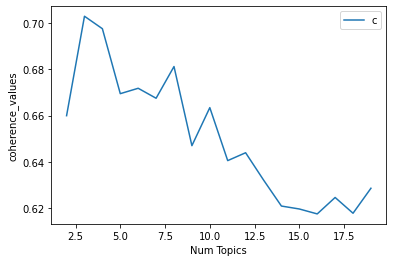

In [26]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("coherence_values")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
#printing coherence scores

for num_topic,score in zip(x,coherence_values):
  print("Number of topics:",num_topic,"has coherence score of:",round(score,4))

Number of topics: 2 has coherence score of: 0.6655
Number of topics: 3 has coherence score of: 0.6785
Number of topics: 4 has coherence score of: 0.6668
Number of topics: 5 has coherence score of: 0.6838
Number of topics: 6 has coherence score of: 0.65
Number of topics: 7 has coherence score of: 0.6653
Number of topics: 8 has coherence score of: 0.669
Number of topics: 9 has coherence score of: 0.6475
Number of topics: 10 has coherence score of: 0.6441
Number of topics: 11 has coherence score of: 0.6428
Number of topics: 12 has coherence score of: 0.6319
Number of topics: 13 has coherence score of: 0.6208
Number of topics: 14 has coherence score of: 0.6329
Number of topics: 15 has coherence score of: 0.6228
Number of topics: 16 has coherence score of: 0.6288
Number of topics: 17 has coherence score of: 0.6316
Number of topics: 18 has coherence score of: 0.6293
Number of topics: 19 has coherence score of: 0.63


##Find out the optimal number of topics based on the coherence score- LDA Mallet


In [0]:
#find the right number of topics for the document

def compute_coherence_score(dictionary, corpus, texts, limit, start=5, step=2):
  """Compute Coherence score for different values of num of topics"""
  coherence_values = []

  model_list = []
  for num_topics in range(start,limit,step):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics= num_topics,id2word=id2word,random_seed=1301, )
    model_list.append(model)
    coherencescore = CoherenceModel(model=model, texts=data_words_final, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencescore.get_coherence())
  

  return model_list, coherence_values

In [0]:
model_list , coherence_values = compute_coherence_score(dictionary=id2word,texts=data_words_final,corpus=corpus,limit=20,start=3,step=1)

In [61]:
print(model_list)
print(coherence_values)

[<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b922e358>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b91d2a20>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b91a3ef0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b922eda0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b91a3a90>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b8cdc588>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b91a3080>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b91448d0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f472ee89588>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46d900f748>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b917fd30>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b922eef0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b91b9ef0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f46b9144208>, <gens

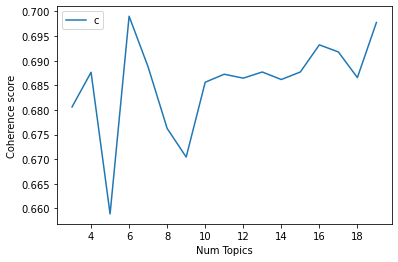

In [64]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
# find the score by the num of topics

for num,score in zip(x,coherence_values):
  print("For number of topics:",num,"the coherence score is:",score)

For number of topics: 3 the coherence score is: 0.680609405570899
For number of topics: 4 the coherence score is: 0.6876432070605303
For number of topics: 5 the coherence score is: 0.6588884156135609
For number of topics: 6 the coherence score is: 0.6990181751903703
For number of topics: 7 the coherence score is: 0.6887123357698276
For number of topics: 8 the coherence score is: 0.6762390042297338
For number of topics: 9 the coherence score is: 0.6704329213886057
For number of topics: 10 the coherence score is: 0.6856217949492186
For number of topics: 11 the coherence score is: 0.6872449160399244
For number of topics: 12 the coherence score is: 0.6864508023323173
For number of topics: 13 the coherence score is: 0.6876983235229766
For number of topics: 14 the coherence score is: 0.6861728877614925
For number of topics: 15 the coherence score is: 0.6876990771958063
For number of topics: 16 the coherence score is: 0.6932092187696446
For number of topics: 17 the coherence score is: 0.69177

#LDAMallet

In [0]:
#Use of LDA mallet model
num_topics  = 4
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path = mallet_path, id2word = id2word, corpus=corpus,num_topics =num_topics)

In [0]:
#print the topic with Mallet

pprint(ldamallet.show_topics(formatted=False))

In [73]:
#find the coherence socre

coherence_model_mallet = CoherenceModel(model = ldamallet, texts= data_words_final, dictionary= id2word, coherence='c_v')
coherence_mallet = coherence_model_mallet.get_coherence()
print("Coherence with Mallet model is:", coherence_mallet)

Coherence with Mallet model is: 0.6958253659306739


#Get dominant topic in each email subject line

In [0]:
def get_dominant_topic(ldamodel=ldamallet,corpus=corpus, texts=data_words_final):

  subjectline_topic_df = pd.DataFrame()

  for i,row in enumerate(ldamodel[corpus]):
    # print(row)
    row=sorted(row,key=lambda x: x[1],reverse=True)

    for j,(t_num,t_prob) in enumerate(row):
      # print(j)
      if j==0:
        tp = ldamodel.show_topic(t_num)
        topic_keywords= ",".join([word for word, prob in tp])
        subjectline_topic_df= subjectline_topic_df.append(pd.Series([int(t_num),round(t_prob,4),topic_keywords]),ignore_index=True)
      else:
        break
  subjectline_topic_df.columns= ['Dominant_topic_number','Topic_prob',"Key_words"]

  original_text = pd.Series(texts)
  subjectline_topic_df= pd.concat([subjectline_topic_df,original_text],axis=1)
  return(subjectline_topic_df)


df_subject_topic = get_dominant_topic(ldamodel=ldamallet,corpus=corpus, texts=data_words_final)

df_dominant_topic=df_subject_topic.reset_index()
df_dominant_topic.columns =['DocNum','TopicNum','TopicPercentContribution','Keywords','OriginalSubject']


In [107]:
display_all(df_dominant_topic)

,DocNum,TopicNum,TopicPercentContribution,Keywords,OriginalSubject
0,0,3.0,0.2818,"tailgate,reward,chapter,ticket,day,season,ask_tour,devil,earn_provide,feedback_website","[reward, summer, flash_sale, inside, secret_word]"
1,1,1.0,0.2596,"event,join,special,regalia,graduation,free,care,newsletter,celebration,student","[save, auto_insurance]"
2,2,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
3,3,2.0,0.3056,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[share, thought, chance, win]"
4,4,2.0,0.2925,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[thought, chance, win]"
...,...,...,...,...,...
5673,5673,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
5674,5674,0.0,0.2596,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question","[case, miss, new]"
5675,5675,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
5676,5676,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]


#Get dominant subject line represented for each topic

In [80]:
#increase the size of the column

pd.options.display.max_colwidth = 100

subjectline_for_topic_df = pd.DataFrame()

subject_topic_grouped = df_subject_topic.groupby('Dominant_topic_number')

for i, group in subject_topic_grouped:
  # print(group)
  subjectline_for_topic_df = pd.concat([subjectline_for_topic_df,group.sort_values(['Topic_prob'],ascending=False).head(1)],axis=0)

# subjectline_for_topic_df=subjectline_for_topic_df.copy()
subjectline_for_topic_df.reset_index(drop=True,inplace=True)

subjectline_for_topic_df.columns=['TopicNum','TopicPercentContribution','TopicKeywords','MostRepresentiveOriginalSubject']

subjectline_for_topic_df.head()

,TopicNum,TopicPercentContribution,TopicKeywords,MostRepresentiveOriginalSubject
0,0.0,0.3182,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question","[news, answer, alumnus, question, travel]"
1,1.0,0.3182,"event,join,special,regalia,graduation,free,care,newsletter,celebration,student","[steak, golf, mountain, support, scholarship]"
2,2.0,0.3304,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[alum, inside_scoop, find_dream, job_launch, business_build, network]"
3,3.0,0.3056,"tailgate,reward,chapter,ticket,day,season,ask_tour,devil,earn_provide,feedback_website","[final, football, sweep, season]"


#Frequency of word counts in Documents

<Figure size 1000x500 with 0 Axes>

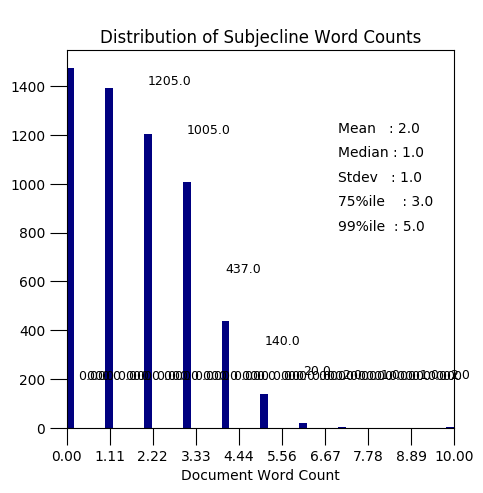

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.OriginalSubject]
# print(doc_lens)
# Plot

plt.figure(figsize=(10,5), dpi=100)
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
plt.hist(doc_lens, bins = 50, color='navy')
plt.text(7,1210, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(7,1110, "Median : " + str(round(np.median(doc_lens))))
plt.text(7, 1010, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(7, 910, "75%ile    : " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(7, 810, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0,1), xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,10,10))
plt.title('Distribution of Subjecline Word Counts', fontdict=dict(size=12))
# plt.yticks(False)


for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+200),fontsize=9)
# Show graphic


#WordClouds for both the Models 1. LDAMallet 2. Gensim's LDA

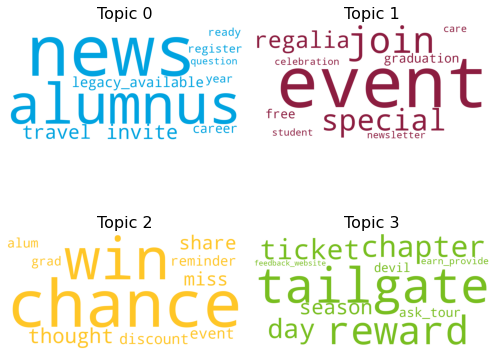

In [81]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20']  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1000,
                  height=500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.title("Results for LDA Mallet",fontsize=22)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

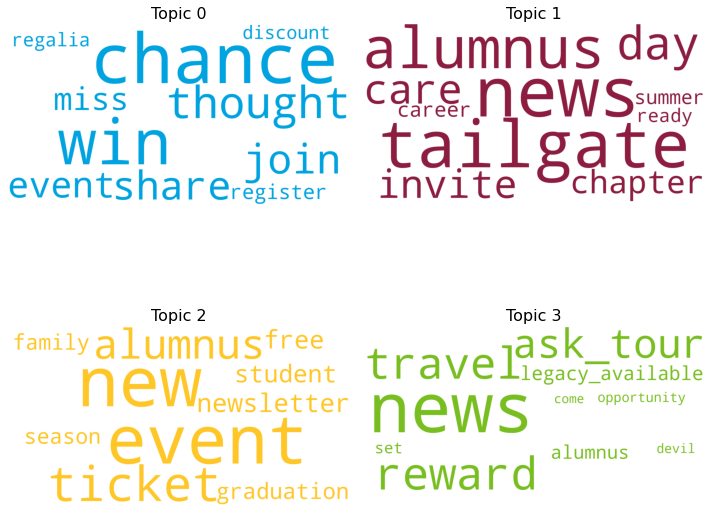

In [82]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20','#00A3E0']  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1500,
                  height=800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics =lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.title("Results for LDA Gensim",fontsize=22)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#Import Email Summary Data

In [0]:
summary_df = pd.read_csv(r'/gdrive/My Drive/KAEMH/EmailSpamAnalysis/Email_Send_Summary_Data 2020-02-05.csv')

In [108]:
display_all(summary_df)

,FactCampaignSummaryId,DimBusinessUnitId,DimCampaignId,TotalSent,TotalHardBounce,TotalSoftBounce,TotalOpens,UniqueOpens,TotalClicks,UniqueClicks,TotalForwards,UniqueForwards,TotalPurchases,UniquePurchasers,TotalPurchaseAmount,ActivityStartDate,LastActivityDate,CreatedBy,CreatedDate,UpdatedBy,UpdatedDate,ETL_Sync_DeltaHashKey
0,536635,1,15240,160,0,0,173,88,30,26,0,0,0,0,0,2018-01-17 11:06:58,2018-10-02 22:37:53,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
1,536636,1,51,1,0,0,9,1,7,1,0,0,0,0,0,2018-01-16 17:24:35,2018-01-17 10:36:12,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
2,536637,1,11163,2,0,0,1,1,0,0,0,0,0,0,0,2018-07-19 09:09:44,2018-07-19 13:43:27,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
3,536638,1,2215,1,0,0,4,1,0,0,0,0,0,0,0,2018-01-25 11:56:43,2018-08-27 14:00:47,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
4,536641,1,13084,13,0,0,2,2,0,0,0,0,0,0,0,2018-02-22 17:01:42,2018-02-22 17:11:33,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78734,2273219,12,107123,1,0,0,0,0,0,0,0,0,0,0,0,2020-02-03 10:58:39,2020-02-03 10:58:39,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN
78735,2273220,107,107124,716,0,0,619,353,57,50,0,0,0,0,0,2020-02-03 10:42:53,2020-02-03 23:56:28,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN
78736,2273221,107,107125,213,0,0,177,102,28,23,0,0,0,0,0,2020-02-03 10:42:47,2020-02-03 23:57:19,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN
78737,2273222,107,107126,1231,0,0,1384,734,183,155,0,0,0,0,0,2020-02-03 10:42:53,2020-02-03 23:55:43,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN


#Concat Topicnum dataframe with Original subject line dataframe

In [110]:
#reset index of filter_filter_df & df_dominant_topic
reset_filter_df=filter_filter_df.reset_index()
reset_dominant_topic=df_dominant_topic.reset_index()

concat_df=pd.concat([reset_filter_df,reset_dominant_topic],axis=1)
concat_df.head()

,level_0,index,DimCampaignId,DimBusinessUnitId,Subject,level_0,index,DocNum,TopicNum,TopicPercentContribution,Keywords,OriginalSubject
0,0,753,752,35,[Test]:This Sun Devil Rewards summer flash sale is ??! (Inside: a secret word),0,0,0,3.0,0.2818,"tailgate,reward,chapter,ticket,day,season,ask_tour,devil,earn_provide,feedback_website","[reward, summer, flash_sale, inside, secret_word]"
1,1,765,764,85,[Test]:You Could Save $509 On Auto Insurance,1,1,1,1.0,0.2596,"event,join,special,regalia,graduation,free,care,newsletter,celebration,student","[save, auto_insurance]"
2,2,779,778,87,ASU????????,2,2,2,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
3,3,801,800,35,[Test]:Reminder: Share your thoughts for a chance to win $250,3,3,3,2.0,0.3056,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[share, thought, chance, win]"
4,4,802,801,35,[Test]:Share your thoughts for a chance to win $250,4,4,4,2.0,0.2925,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[thought, chance, win]"


In [113]:
#cleaning datacolumns
concat_df.drop('level_0',axis=1,inplace=True)
concat_df

,index,DimCampaignId,DimBusinessUnitId,Subject,index,DocNum,TopicNum,TopicPercentContribution,Keywords,OriginalSubject
0,753,752,35,[Test]:This Sun Devil Rewards summer flash sale is ??! (Inside: a secret word),0,0,3.0,0.2818,"tailgate,reward,chapter,ticket,day,season,ask_tour,devil,earn_provide,feedback_website","[reward, summer, flash_sale, inside, secret_word]"
1,765,764,85,[Test]:You Could Save $509 On Auto Insurance,1,1,1.0,0.2596,"event,join,special,regalia,graduation,free,care,newsletter,celebration,student","[save, auto_insurance]"
2,779,778,87,ASU????????,2,2,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
3,801,800,35,[Test]:Reminder: Share your thoughts for a chance to win $250,3,3,2.0,0.3056,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[share, thought, chance, win]"
4,802,801,35,[Test]:Share your thoughts for a chance to win $250,4,4,2.0,0.2925,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[thought, chance, win]"
...,...,...,...,...,...,...,...,...,...,...
5673,106068,106067,35,"Daily Email Marketing Report for %%=Format(DateAdd(NOW(),-1,''d''),''MMMM dd, yyyy'')=%%",5673,5673,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
5674,106069,106068,35,In case you missed it: Meet ASU’s new CMO,5674,5674,0.0,0.2596,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question","[case, miss, new]"
5675,106338,106337,35,"Daily Email Marketing Report for %%=Format(DateAdd(NOW(),-1,''d''),''MMMM dd, yyyy'')=%%",5675,5675,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]
5676,106542,106541,35,"Daily Email Marketing Report for %%=Format(DateAdd(NOW(),-1,''d''),''MMMM dd, yyyy'')=%%",5676,5676,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[]


#Merge derived topics with email summary stats

In [115]:
#merge
summary_topic_df = pd.merge(concat_df,summary_df,on=['DimCampaignId','DimBusinessUnitId'])
summary_topic_df

,index,DimCampaignId,DimBusinessUnitId,Subject,index,DocNum,TopicNum,TopicPercentContribution,Keywords,OriginalSubject,FactCampaignSummaryId,TotalSent,TotalHardBounce,TotalSoftBounce,TotalOpens,UniqueOpens,TotalClicks,UniqueClicks,TotalForwards,UniqueForwards,TotalPurchases,UniquePurchasers,TotalPurchaseAmount,ActivityStartDate,LastActivityDate,CreatedBy,CreatedDate,UpdatedBy,UpdatedDate,ETL_Sync_DeltaHashKey
0,753,752,35,[Test]:This Sun Devil Rewards summer flash sale is ??! (Inside: a secret word),0,0,3.0,0.2818,"tailgate,reward,chapter,ticket,day,season,ask_tour,devil,earn_provide,feedback_website","[reward, summer, flash_sale, inside, secret_word]",549105,1,0,0,0,0,0,0,0,0,0,0,0,2018-08-07 10:02:39,2018-08-07 10:02:39,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
1,765,764,85,[Test]:You Could Save $509 On Auto Insurance,1,1,1.0,0.2596,"event,join,special,regalia,graduation,free,care,newsletter,celebration,student","[save, auto_insurance]",558635,1,0,0,0,0,0,0,0,0,0,0,0,2018-08-07 11:23:49,2018-08-07 11:23:49,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
2,779,778,87,ASU????????,2,2,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[],655194,604,0,0,94,67,26,10,0,0,0,0,0,2018-08-07 19:35:43,2019-01-12 18:15:11,dbo,2019-01-17 11:35:21,dbo,2019-01-17 11:35:21,NaN
3,801,800,35,[Test]:Reminder: Share your thoughts for a chance to win $250,3,3,2.0,0.3056,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[share, thought, chance, win]",549145,1,0,0,0,0,0,0,0,0,0,0,0,2018-08-08 16:03:48,2018-08-08 16:03:48,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
4,802,801,35,[Test]:Share your thoughts for a chance to win $250,4,4,2.0,0.2925,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[thought, chance, win]",549296,1,0,0,43,1,0,0,0,0,0,0,0,2018-08-08 16:11:40,2018-09-06 14:07:27,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447,106068,106067,35,"Daily Email Marketing Report for %%=Format(DateAdd(NOW(),-1,''d''),''MMMM dd, yyyy'')=%%",5673,5673,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[],2272866,5,0,0,5,3,0,0,0,0,0,0,0,2020-01-30 10:03:40,2020-01-30 15:09:44,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN
5448,106069,106068,35,In case you missed it: Meet ASU’s new CMO,5674,5674,0.0,0.2596,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question","[case, miss, new]",2272867,530,0,0,325,129,27,9,0,0,0,0,0,2020-01-30 08:00:50,2020-02-03 16:15:17,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN
5449,106338,106337,35,"Daily Email Marketing Report for %%=Format(DateAdd(NOW(),-1,''d''),''MMMM dd, yyyy'')=%%",5675,5675,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[],2272964,5,0,0,1,1,0,0,0,0,0,0,0,2020-01-31 10:03:43,2020-01-31 10:28:07,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN
5450,106542,106541,35,"Daily Email Marketing Report for %%=Format(DateAdd(NOW(),-1,''d''),''MMMM dd, yyyy'')=%%",5676,5676,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[],2272991,5,0,0,4,3,0,0,0,0,0,0,0,2020-02-01 10:05:39,2020-02-03 09:44:29,dbo,2020-02-05 07:18:55,dbo,2020-02-05 07:18:55,NaN


#Naming the topics and adding to the dataframe

In [128]:
#Creating names for each topic and adding a seperate column for the same
conditions = [summary_topic_df['TopicNum']==0.0,summary_topic_df['TopicNum']==1.0,summary_topic_df['TopicNum']==2.0,summary_topic_df['TopicNum']==3.0]

values =['News_Alumnus','Join_Event','Offers_Share','Rewards_Tailgate']

summary_topic_df['TopicName']=np.select(conditions,values,'TopicNum')
summary_topic_df.head()

,index,DimCampaignId,DimBusinessUnitId,Subject,index,DocNum,TopicNum,TopicPercentContribution,Keywords,OriginalSubject,FactCampaignSummaryId,TotalSent,TotalHardBounce,TotalSoftBounce,TotalOpens,UniqueOpens,TotalClicks,UniqueClicks,TotalForwards,UniqueForwards,TotalPurchases,UniquePurchasers,TotalPurchaseAmount,ActivityStartDate,LastActivityDate,CreatedBy,CreatedDate,UpdatedBy,UpdatedDate,ETL_Sync_DeltaHashKey,TopicName
0,753,752,35,[Test]:This Sun Devil Rewards summer flash sale is ??! (Inside: a secret word),0,0,3.0,0.2818,"tailgate,reward,chapter,ticket,day,season,ask_tour,devil,earn_provide,feedback_website","[reward, summer, flash_sale, inside, secret_word]",549105,1,0,0,0,0,0,0,0,0,0,0,0,2018-08-07 10:02:39,2018-08-07 10:02:39,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN,Rewards_Tailgate
1,765,764,85,[Test]:You Could Save $509 On Auto Insurance,1,1,1.0,0.2596,"event,join,special,regalia,graduation,free,care,newsletter,celebration,student","[save, auto_insurance]",558635,1,0,0,0,0,0,0,0,0,0,0,0,2018-08-07 11:23:49,2018-08-07 11:23:49,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN,Join_Event
2,779,778,87,ASU????????,2,2,0.0,0.2500,"news,alumnus,invite,travel,legacy_available,career,register,year,ready,question",[],655194,604,0,0,94,67,26,10,0,0,0,0,0,2018-08-07 19:35:43,2019-01-12 18:15:11,dbo,2019-01-17 11:35:21,dbo,2019-01-17 11:35:21,NaN,News_Alumnus
3,801,800,35,[Test]:Reminder: Share your thoughts for a chance to win $250,3,3,2.0,0.3056,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[share, thought, chance, win]",549145,1,0,0,0,0,0,0,0,0,0,0,0,2018-08-08 16:03:48,2018-08-08 16:03:48,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN,Offers_Share
4,802,801,35,[Test]:Share your thoughts for a chance to win $250,4,4,2.0,0.2925,"chance,win,thought,share,miss,event,discount,reminder,alum,grad","[thought, chance, win]",549296,1,0,0,43,1,0,0,0,0,0,0,0,2018-08-08 16:11:40,2018-09-06 14:07:27,dbo,2018-11-16 14:35:01,dbo,2018-11-16 14:35:01,NaN,Offers_Share


In [0]:
summary_topic_df.to_csv('/gdrive/My Drive/KAEMH/EmailSpamAnalysis/Summary_Email_Topics.csv')